# Статегия взаимодействия с клиентами финтес-центра 

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. В данной работе приводится анализ этих данных и выдвигатся рекомендации по удержанию клиентов 

#### Цели и задачи


Цель исследования — провести анализ и подготовить план действий по удержанию клиентов. А именно:
1. Спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
2. Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
3. Проанализировать основные признаки, наиболее сильно влияющие на отток;
4. Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

#### План работы

1. Общая информация 
2. Исследовательский анализ данных (EDA)
3. Модель прогнозирования оттока клиентов
4. Кластеризация клиентов
5. Выводы и рекомендации по работе с клиентами



### Общая информация 

In [1]:
#импортируем все необходимые библиотеки 
import pandas as pd
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans



In [2]:
df = pd.read_csv('C:/Users/alfro/Documents/Daria_Jupyter/Datasets/gym_churn.csv')

display(df.head())
df.info()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Из описания известно, что файл содержит данные за месяц до оттока и факт оттока клиентов на определённый месяц. Каждая строка содержит информацию об одном клиенте, всего таких строк 4000, а признаков по которым описывается клиент - 14. Вот их описание: 
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон;
- 'Churn' — факт оттока в текущем месяце.

Таким образом можно сказать, что у нас 4000 наблюдений, для которых есть данные о 13 признаках и целевой перемнной (столбец 'Churn')

В данных нет пропусков, все столбцы названы корректно. Для удобства обращения к столбцам уберем из названия большие буквы, приведя все к нижнему регистру 

In [3]:
new_cols = df.columns.str.lower()
df.columns = new_cols
df.sample()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
3406,1,1,1,0,1,6,1,36,3.66082,6.0,0,0.39267,0.263513,0


Основной тип  данных - int64: им закодированы 10 столбцов, еще четыре столбца содержатся в типе float64. Что касается столбцов про пол, сотрудников компании-партнёра, проживание в ближайшем районе, промо-акции, наличие телефона, факта посещения и факта оттока (7 столбцов), они все являются по смыслу булевыми, то есть принимают значения 0 или 1. Для цели нашей работы вполне подойдет и тип int64, но стоит заметить что такой тип данных занимает 8 байт для каждой записи, что не очень целесообразно для хранения данных.

In [4]:
df['month_to_end_contract'].unique()

array([ 5., 12.,  1.,  6.,  3., 10., 11.,  9.,  4.,  7.,  8.,  2.])

Средние частоты посещения и средняя выручка от других услуг даны в тип float64, что логично, так как это могут не быть целые числа, а вот стоблец со сроком окончания абонемента тоже дан в float, что странно, так как в нем хрантяся данные о количестве месяцев в целых числах (столбцы 'Lifetime' и 'Contract_period также содержат количесвто месяцев и они в целых числах). Для единообразия таблицы переведем данные из этого стоблца также в целочисленные тип 

In [5]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int64')
#df['month_to_end_contract']

На всякий случай проверим дубликаты 

In [6]:
print("Колличество дубликатов в таблице:", df.duplicated().sum())

Колличество дубликатов в таблице: 0


#### Вывод

В данных нет пропусков и нет дубликатов, столбцы названы корректно, типы данных подходят для дальнейшей работы 

### Исследовательский анализ данных 

Посмотрим на средние значения, стандартные отклонения и распределения всех признаков на целом датасете

In [7]:
#df.describe()
df[[ 'age', 'avg_additional_charges_total', 'month_to_end_contract',
    'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month' ]].describe()

,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052
std,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906
min,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003
50%,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574
75%,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336
max,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783


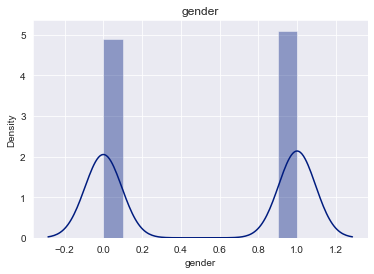

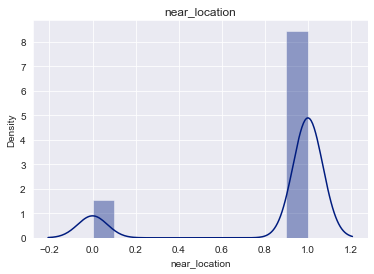

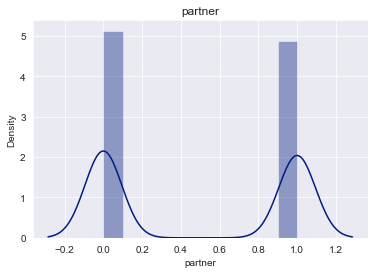

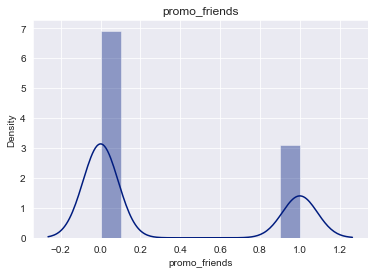

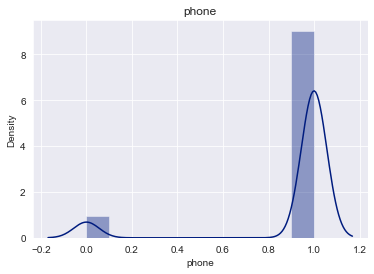

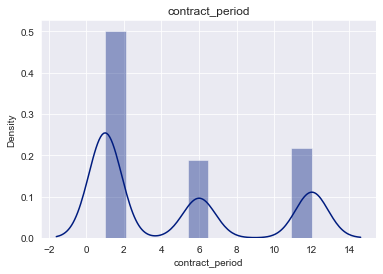

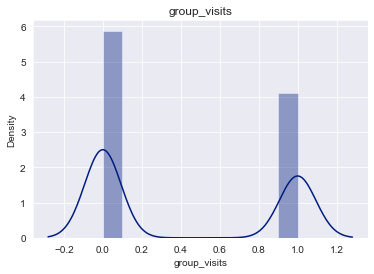

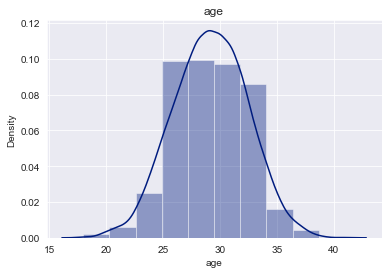

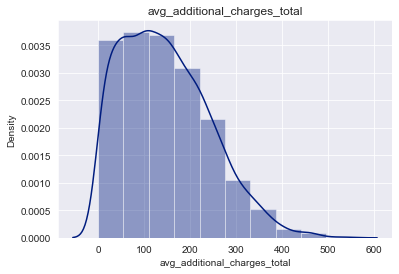

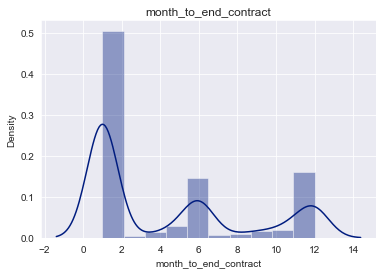

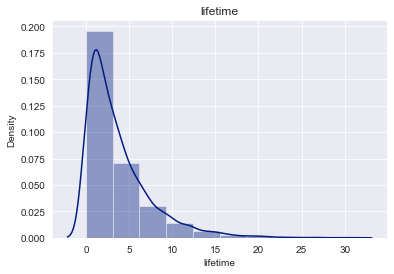

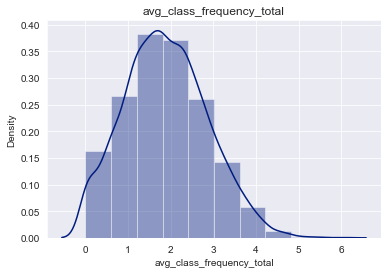

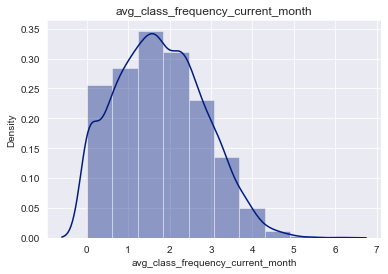

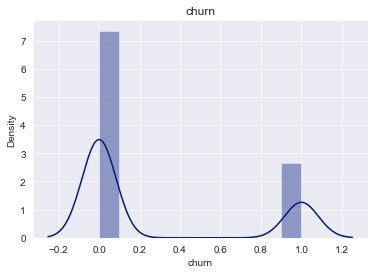

In [8]:
sns.set_style("darkgrid")
sns.set_palette("dark")

for col in df.columns:
    sns.distplot(df[col], bins=10)
    plt.title(col)
    plt.show() 
   

Графики и описание таблицы позволят следующим образом охарактеризовать клиентов фитнес-клуба: 
- Мужчины и женщины распределены примерно поровну, и сотрудников-партнеров клуба тоже примерно половина. 
- Ощутимо меньшая часть датасета живет или работат не в районе расположения клуба. Примерно треть клиентов пришло по промо-акции приведи друга. 
- Для подавляющего большинства клиентов есть номера телефонов 
- Чуть больше половины клиентов имеет абонементы на 1 месяц и примерно по четверти клиентов на полгода и на год 
- Клиентов, которые посещают групповые занятия больше, чем тех кто не посещает 
- Средний возраст клиента 29 лет,и при этом распредление по возрасту очень близко к нормальному 
- Сумарная выручка от других услуг фитнес-клуба в среднем составляет 147 едениц, при этом у 75% клиентов она не превышает 210 едениц. Стандартное откодонение довольно велико - 96
- Срок до оокончания текущего абонемента по своему рапредлению  похож на длительность текущего абонемента - большинству остался 1 месяц и две меньшие, но примерно равные группы - 6 и 12 месяцев
- Большая часть клиентов из этого датасета появилась у фитнес-клуба относительно недавно - половина клиентов впервые пришли в клуб не познее 3х месяцев назад. А те кто пришли полода назад и позднее составляют более 75% 
- В среднем люди ходят в фитнес-клуб около 2х раз в неделю - распределение напоминает нормальное, хоть и с большим  стандартным отклонением 
- Если смотреть на недельную часоту посещения именно за последний месяц, то датасет слегка скашивается влево, что говорит о том, что большее количесвто людей пришли 1 раз неделю 
- Примерно четверть клиетов отвалилась за последний месяц 

Теперь посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался. А так же построим столбчатые гистограммы и распределения признаков для этих групп

In [9]:
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


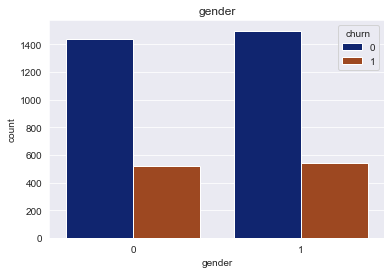

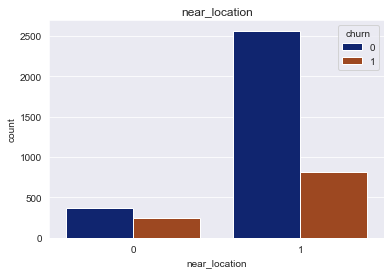

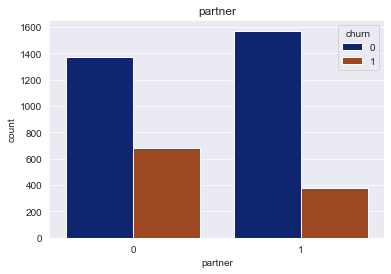

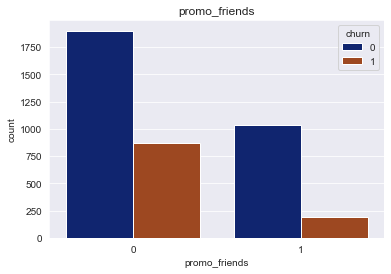

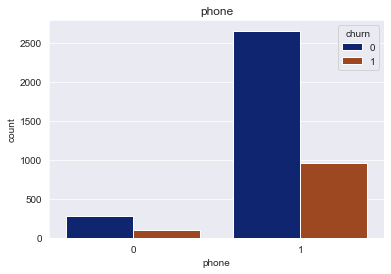

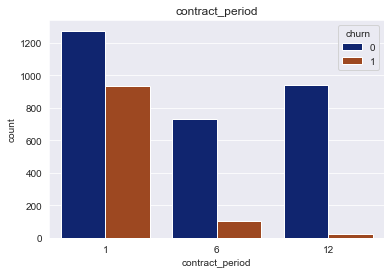

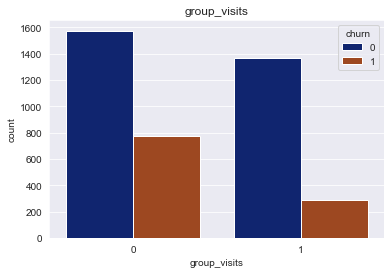

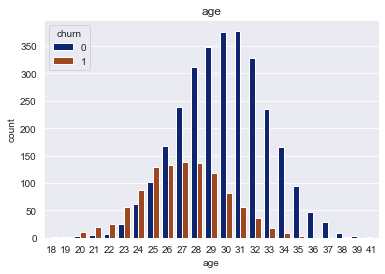

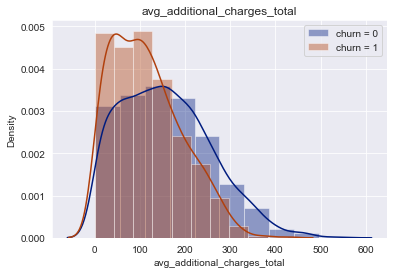

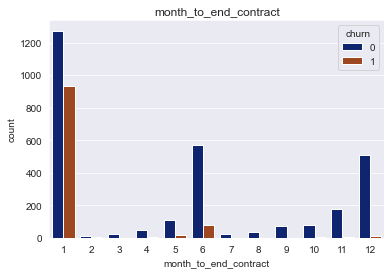

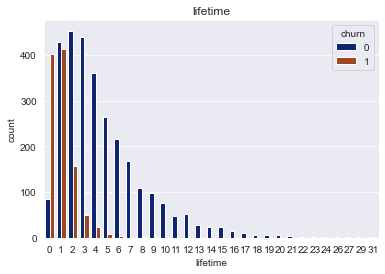

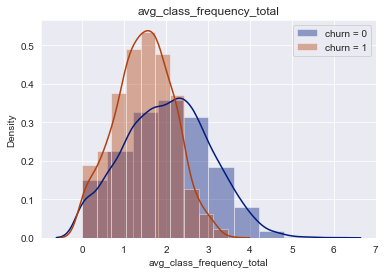

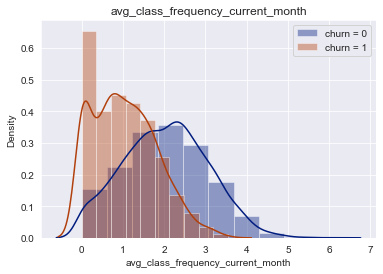

In [10]:
#для тех данных, которые даны целым числом построим столбчатые диаграммы,
# а для тех, что выражают некое среднее - гистограммы 

for col in df.drop('churn', axis=1).columns:
    if df[col].dtypes == 'int64':
        sns.countplot(x = df[col], hue='churn', data=df)
    else:
        sns.distplot(df.query('churn == 0')[col], bins=10, label='churn = 0')
        sns.distplot(df.query('churn == 1')[col], bins=10, label='churn = 1')
        plt.legend()
    plt.title(col)
    plt.show()

Исходя из графиков, построенных таким образом, можно сделать следующие выводы: 
- распредления по полу, расположение и наличие телефона почти совпадают у тех кто ушел и тех, кто остался, поэтому по графикам нельзя сделать выводы о сильном влиянии этих факторов; 
- клиенты партнеров менее и те, кто пришел по приглашению друзей менее склонны отказываться от услуг фитнес-клуба
- Те, кто покупают абонементы на длительный срок (от 6 мес) менее склонны отваливаться, так же как и те, кто ходят на групповые занятия. В подтверждении этому еще стоит сказать, что больше всего склонны отваливаться те, клиенты у которыех осталось в районе месяца от абонемента (в противоположность тем, у кого осталось больше времени по абонементу)
- Люди до 26 более склонны отказываться от услуг фитнеса, чем те, кто старше
- Те, кто пплатит за дополнительные услуги меньше более склонны к тому, чтобы отказаться от услуг финеса
- Основная масса клиентов отваливается поле первого месяца
- У клиентов, которые склонны к тому, чтобы отказаться от услуг фитнеса, средняя посещаемость ниже - от 0 до 1 раза в неделю, в то время как у тех, кто осается - это 2 и больше раза в неделю 

Также посмотрим на много ли выбросов содержат данные, которые предсавлят из себя некое число. Это будут столбцы с возрастом, средним количесвтвом посещений и средней выручкой. Длительность текущего действующего абонемента не включаем, так как там есть всего несоклько зафиксированных значений 

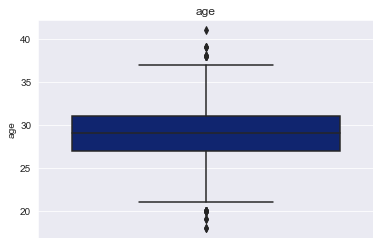

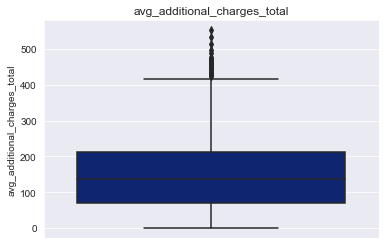

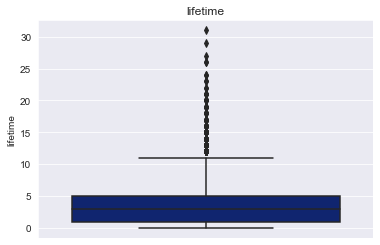

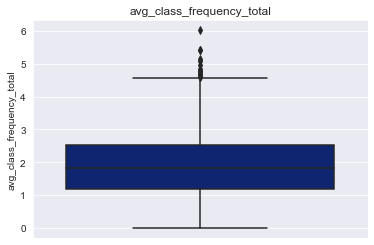

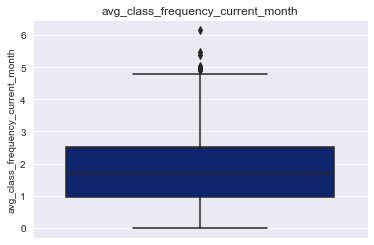

In [11]:
cols_nb = [ 'age', 'avg_additional_charges_total',
    'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month' ]

for col in cols_nb:
    sns.boxplot(y = df[col], data = df)
    plt.title(col)
    plt.show()   

Как видно по графикам боксплот почти каждый признак содержит выбросы. Зрительно больше всего их в lifetime и avg_additional_charges_total. Возможно для решения последующих задач далее придется почистить данные  

Мы рассмотртели на признаки в группе в целом,на то, как они выражены в зависимости от целевой переменной, а теперь посмотрим на них в сравнении друг с другом и отобразим матрицу корреляции на тепловой карте. 

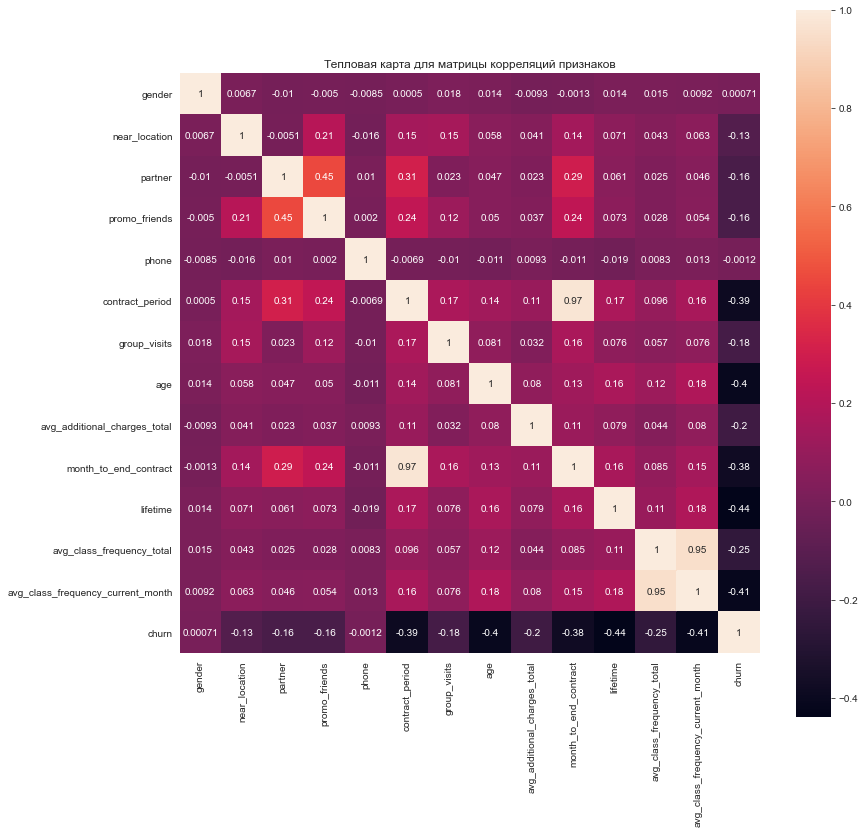

In [12]:
cm = df.corr() 

plt.figure(figsize=(13,13))
sns.heatmap(cm, annot=True, square=True)
plt.title('Тепловая карта для матрицы корреляций признаков')
plt.show()


Среди признако есть 2 пары мультиколинеарных - это пара сontract_period и month_to_end_contact и пара avg_class_frequency_total  и avg_class_frequency_current_month  (это было также заментно и на этапе постороения графиков). Неудивительно, что в базе за 1 месяц длительность текущего абонемента и срок до его окончания сильно коррелируют. Также Средення частота посещений за последний месяц очень похожа на среднюю частоту в целом

Если говорить о линейной зависимость всез признаков и целевой переменной, то стоит сказать, что такие признаи как пол и телефон имеют очень слабую корреляцию. Сильной же корреляции с целевой переменной нет, однако у пяти признаков есть обратная корреляции, которую стоит изучить подробнее 

#### Вывод

На этапе первоначального анализ данных были рассмотрены все признаки и их выраженность в наблюдениях, что было несложно сделать, та как все признаки числовые. Часть признаков рапределена нормально (или довольно близко к нормальности), но также в данных есть выбросы. Были выявлены 2 пары мультиколлинеарных признаков 

### Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Будем обучать модель следующими алгоритмами: логистической регрессией и случайным лесом.

In [13]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(['churn'], axis=1)
y = df['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# создадим объект класса StandardScaler и применим его к обучающей выборке
# обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)


In [14]:
#зададим модели 
model_lr = LogisticRegression(solver='liblinear')
model_rf = RandomForestClassifier(n_estimators = 100, random_state=0) 

In [15]:
# обучим модель логистической регрессией
model_lr.fit(X_train, y_train)

predictions_lr = model_lr.predict(X_test) 

In [16]:
# обучим модель алгоритмом случайный лес
model_rf.fit(X_train_st, y_train)

predictions_rf = model_rf.predict(X_test_st) 

In [17]:
#сформируем датафрейм из метрик для обеих моделей  
metrics = pd.DataFrame(
    {'Модель' : ['Логистическая регрессия', 'Случайный лес'],
     'Accuracy' : ['{:.2f}'.format(accuracy_score(y_test, predictions_lr)), 
                   '{:.2f}'.format(accuracy_score(y_test, predictions_rf))],
     
    'Precision' : ['{:.2f}'.format(precision_score (y_test, predictions_lr)),
                   '{:.2f}'.format(precision_score(y_test, predictions_rf))],  
     
    'Recall': ['{:.2f}'.format(recall_score(y_test, predictions_lr)),
               '{:.2f}'.format(recall_score(y_test, predictions_rf))]    
    })
metrics

,Модель,Accuracy,Precision,Recall
0,Логистическая регрессия,0.93,0.86,0.83
1,Случайный лес,0.92,0.84,0.81


In [18]:
df['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

Метрики логистической регресси выглядят более перспективно, однако стоит помнить, что accuracy работает не всегда, а только при условии баланса классов — когда объектов каждого класса примерно поровну 50 на 50. Как мы помним примерно чеверть всех клиентов отвалилась, а три четверти осталось, то есть балланс скорее 75 на 25, поэтому эта метрика хоть и оптимистина, но  в данном случае не очень показательна. А вот precision и recall, которые хоть и несколько меньше, но оценивают модель без привязки к соотношению классов. Precion говорит о том, что модель спрогнзирвала около 85%  правильных ответов только среди целевого класса (то есть тех, кто остается). В данном случае иммет смысл обращать внимание именно на этот показатель, например, при планировании маркетингового бюджета - если привлечение одного клиента стоит, например, стоит очень дорого. 

#### Вывод

Метрики модели обученно методом логистической регрессии несколько выше метрик модели, обученной методом случайного леса (но незначительно). При неравенстве двух классов наиболее нформативными метриками следует считать precision и recall. 

### Кластеризация клиентов

In [19]:
#стандартизируем данные без столбца с оттоком
X = df.drop(['churn'], axis=1)
sc = StandardScaler()
X_sc = sc.fit_transform(X)

#Построbv матрицу расстояний функцией linkage() на стандартизованных данных
linked = linkage(X_sc, method = 'ward') 

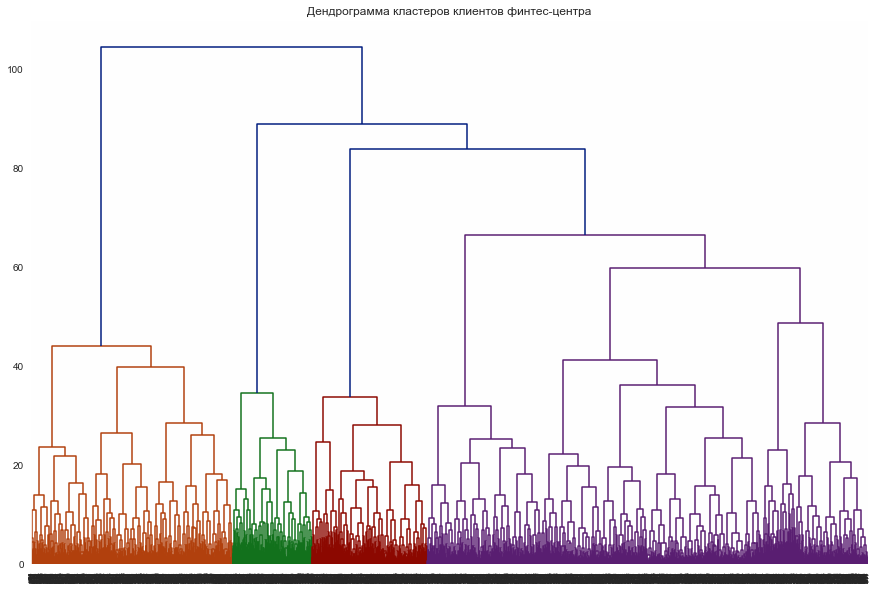

In [20]:
#отрисуйте дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма кластеров клиентов финтес-центра')
plt.show()


На основании полученного графика логично выделить 4 кластера клиентов (по цветам, используемым на графике). Однако самый последний кластер довольно большой, поэтому теперь попробуем выделить 5 кластеров, но уже другим методом - на основании алгоритма K-Means 

In [21]:
km = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров - 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров

Добавим в таблицу еще один столбец, в котором будет указан номер кластера. А также посчитаем средние от всех показателей и визуализируем распределения признаков

In [22]:
df['cluster_km'] = labels
#df.head()
df.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


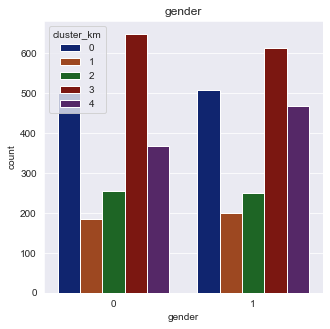

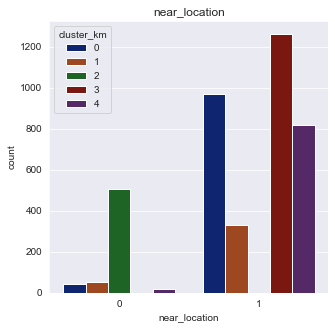

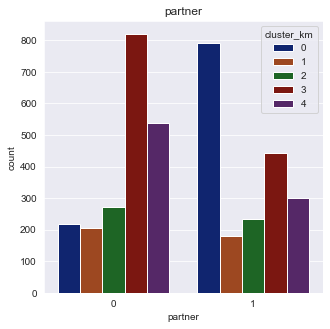

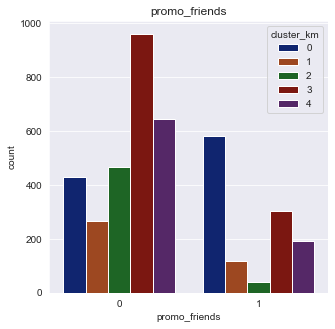

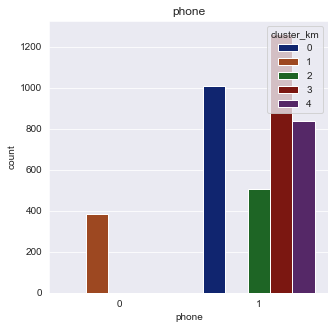

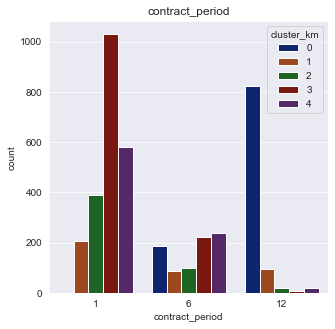

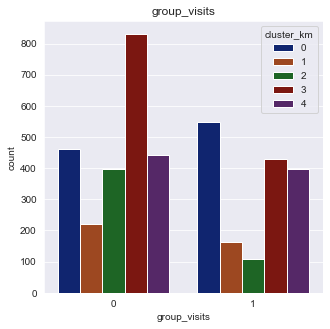

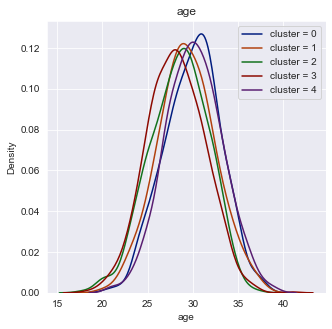

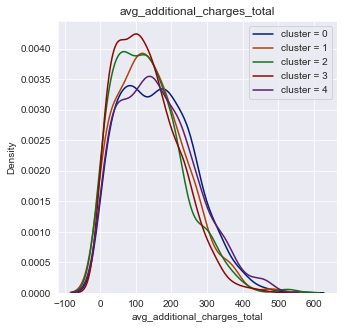

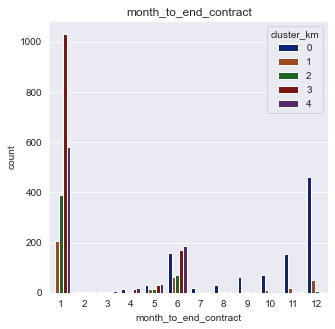

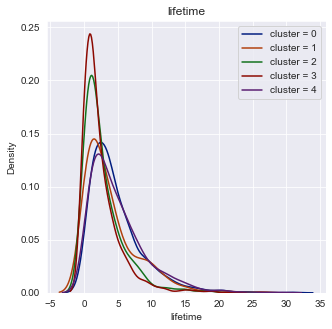

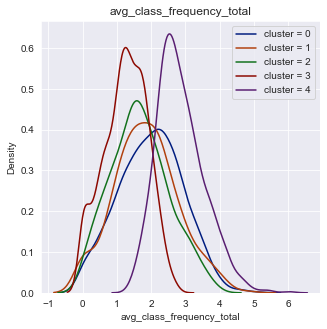

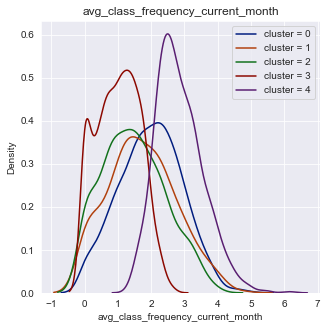

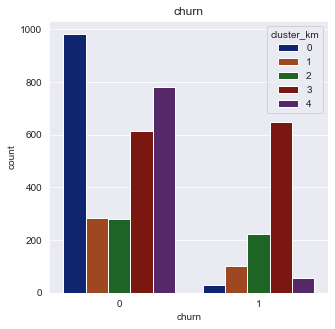

In [23]:

for col in df.drop('cluster_km', axis=1).columns:
    plt.figure(figsize=(5,5))
    if col in ['gender', 'phone', 'near_location', 'partner', 'promo_friends', 'contract_period', 'group_visits', 'churn',
              'month_to_end_contract']:
        sns.countplot(x = df[col], hue='cluster_km', data=df)
    
    else:
        sns.distplot(df.query('cluster_km == 0')[col], bins=10, hist=False, label='cluster = 0')
        sns.distplot(df.query('cluster_km == 1')[col], bins=10, hist=False, label='cluster = 1')
        sns.distplot(df.query('cluster_km == 2')[col], bins=10, hist=False, label='cluster = 2')
        sns.distplot(df.query('cluster_km == 3')[col], bins=10, hist=False, label='cluster = 3')
        sns.distplot(df.query('cluster_km == 4')[col], bins=10, hist=False, label='cluster = 4')
        plt.legend()
    plt.title(col)
    plt.show()

Получились следующие кластеры: 
- Кластер 0 - один из самых больших кластеров, клиенты в основном живут или работают рядом с фитнесом, скорее являются сотрудниками компании-партнёра клуба, часто приходят по промо от друзей, покупают абонементы на год, им около 30 или чуть больше, в среднем ходят в фитнес-клуб 2 раза в неделю и могут тратить различные суммы на дополнительные услуги. Такие клиенты не склонны отваливаться 
- Кластер 1 - самый малочисленный кластер. Эти клиеты тоже скорее живут или рабтают недалеко, скорее они пришли без про от кого-то из друзей, у них не указан телефон, они скорее имебт абонемент на 1 месяц, но могут и на более длительный срок, они слегка моложе 30, на занятия ходят скорее около 2х раз в неделю (или меньше). Эта группа клиетов тоже довольно преданна клубу. 
- Кластер 2 - средний по размеру кластер. Это клиенты, которые не живут и не работают в районе фитнеса, скорее пришли без промо, пользуются абонементом на 1 месяц, неохотно посещают групповые занятия, взраст около 30, ходят реже 2х раз в неделю. У этой группы довольно высок уровень оттока. 
- Кластер 3 - самый многочисленый кластер (около трети всех клиентов). Клиенты живут или работают в раоне фитнеса, скорее не являются сотрудниками компании-партнёра, скорее не приходят по промо, покупают абонементы на месяц (или редже на полгода), в основном не посещают групповые занятия, им около 28 лет, они тратят меньше всего денег на дополнительные услуги, большая их часть пришла в клуб менее полугода назад, в среднем они ходят 1 раз в неделю. Доля тех, кто отваливается среди них довольно высока - выше, чем у всех других групп
- Кластер 4 - также средний по размеру. Клиенты из этого кластера проживают рядом, в основном не пришли по промо, большая часть имет абонементы на 1 месяц, но иногда и на полгода, в среднем им 30 лет, они татят различные суммы на дополнительные услуги, посещают клуб около 3х раз в неделю (или чуть меньше). Такие клиентв не склонны переставать пользоваться услугами фитнеса. 

Выведем оттельно абсолютные и относительные показатели оттока по группам

In [24]:
churn_by_clusters = df.groupby('cluster_km').agg({'churn' : ['count', 'sum', 'mean']}).reset_index()
churn_by_clusters

cluster_km churn               
             count  sum      mean
0          0  1010   28  0.027723
1          1   385  103  0.267532
2          2   505  224  0.443564
3          3  1262  649  0.514263
4          4   838   57  0.068019

Как видно из таблицы в кластерах 2 и 3 самый высокий уровень оттока, а в кластерах 0 и 4 (которые вместе составляют чуть меньше половины всей выборки) отток довольно низкий 

#### Вывод 

При помощи инстументов кластеризации можно выделить 4 или 5 классов клиентов фитнес-клуба. Если мы говорим о выделении 5 классов, то можно среди них есть как минимум 2 группы, где отток клиетов ниже, чем у остальных. Эти группы объединяет то, что средний возраст в них слегка выше, чем в других группах, клиенты живут или работают рядом, и тратят различнын сумы на доплнительные услуги. Различается у них то, что первой "верной" группе оказались в основном сотрудники компании-партнёра клуба, которые покупают абонементы на год и в среднем ходят в фитнес-клуб 2 раза в неделю. В другой группе оказались клиенты, которые покупают абонементы на 1 месяц, иногда на полгода и посещают клуб около 3х раз в неделю (или чуть меньше).
Про те группы, у которых отток выше можно сказать, что они в целом покупают абонементы на 1 месяц, меньше ходят на групповые занятия и в центр в целом (по количесву раз в неделю), склоны меньше тратить на доплнительные услуги и в большинстве как клиенты появились относительно недавно

### Выводы и реккомендации 

На основании полученных данных можно поробовать бороться с оттоком клиентов следующим образом: попытаться наделить клиентов из оттекающих кластеров "признаками" клиентов, которые с фитнес-клубом давно, а именно: 
- сделать так, чтобы клиенты приходили в клуб чаще (так как те, кто чаще ходит менее склонен отваливаться). Это могут быть различные групповые занятия, какие-то акции, возможно мероприятия, новые виды тренировок. Также стоит рассмотреть возмжность расширения дополнительных услуг - чтобы у клиента было несколько поводо прийти в фитнес-клуб (речь идет о кафе, массаже, косметических услугах, консультациях со специалистами, какие-то десткие развлечения и т.д.)
- Стимулировать заключение договоров на более длительный срок. С одной стороны ,ожидаемо, что клиенты, которые знакомы с клубом больше по времени реже оттекают, однако всегда будет часть тех, кто отзанимался месяц и ушел (в частности таких клиентов много в кластере 3). С другой стороны, неизбежно, что часть таких людей не станет клиентами в долгой перспективе, поэтому их возможно стоит рассмотреть подробнее - внутри них выделить кластеры и на основе этой информации попытаться, например, заключить долгоиграющие договры с теми, с кем это перспективнее 
- На посещение фитнес-клуба сильно влияет его расположение - почти все, кто с фитнесом давно, работает или живет в районе фитнес-клуба. Возможно, стоит поискать потенциальных клиентов среди тех жителей района фитнес-клуба, которые еще не ходят в фитнес-клуб - сделать им какие-то дополнительные предложения или обзавестить компаниями-партнерами неподалеку 